# Testing `plotting` module

**Authorship:**
Adam Klie, *07/12/2022*
***
**Description:**
Code to test the `plotting` module of EUGENe.

In [1]:
import numpy as np
import pandas as pd

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

import eugene as eu

Global seed set to 13


# Load processed `random1000_10` dataset

In [2]:
# Loads a random dataset of 1000 sequences of length 66 with 10 potential targets
sdata = eu.dl.read_h5sd("../../eugene/datasets/random1000_10/random1000_10_processed.h5sd")
sdata

SeqData object with = 1000 seqs
seqs = (1000,)
names = (1000,)
rev_seqs = (1000,)
ohe_seqs = (1000, 66, 4)
ohe_rev_seqs = (1000, 66, 4)
seqs_annot: 'ACTIVITY_0', 'ACTIVITY_0_PREDICTIONS', 'ACTIVITY_1', 'ACTIVITY_1_PREDICTIONS', 'ACTIVITY_2', 'ACTIVITY_2_PREDICTIONS', 'ACTIVITY_3', 'ACTIVITY_3_PREDICTIONS', 'ACTIVITY_4', 'ACTIVITY_4_PREDICTIONS', 'ACTIVITY_5', 'ACTIVITY_5_PREDICTIONS', 'ACTIVITY_6', 'ACTIVITY_6_PREDICTIONS', 'ACTIVITY_7', 'ACTIVITY_7_PREDICTIONS', 'ACTIVITY_8', 'ACTIVITY_8_PREDICTIONS', 'ACTIVITY_9', 'ACTIVITY_9_PREDICTIONS', 'LABEL_0', 'LABEL_1', 'LABEL_2', 'LABEL_3', 'LABEL_4', 'LABEL_5', 'LABEL_6', 'LABEL_7', 'LABEL_8', 'LABEL_9', 'SEQ_LEN', 'TRAIN'
pos_annot: PyRanges object with 1436 features
seqsm: 'InputXGradient_imps_pca', 'InputXGradient_imps_umap'
uns: 'InputXGradient_imps', 'pfms'

# Raw data plotting functions (`_catplot.py`)

Text(0.5, 24.80000000000002, 'GATA Activity')

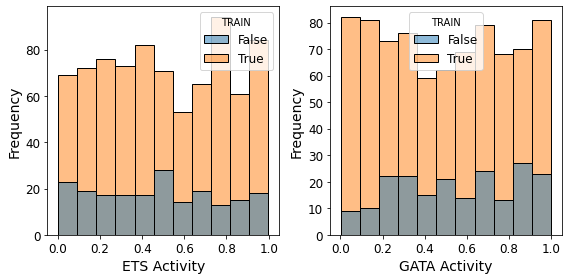

In [3]:
# Histograms
ax = eu.pl.histplot(sdata, keys=["ACTIVITY_0", "ACTIVITY_1"], orient="h", hue="TRAIN", return_axes=True)
ax[0].set_xlabel("ETS Activity")
ax[1].set_xlabel("GATA Activity")

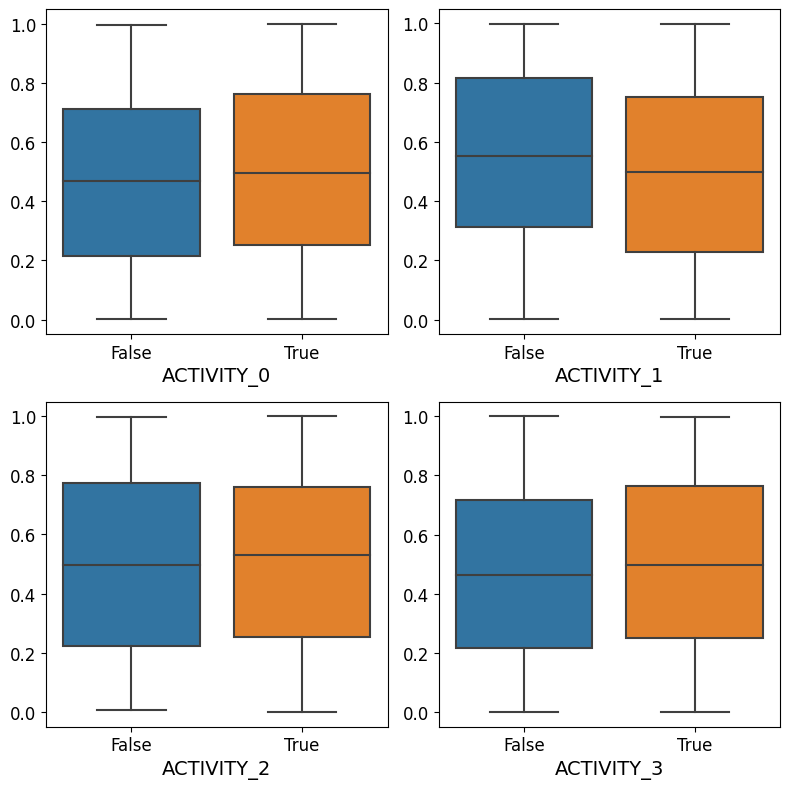

In [4]:
# Boxplots
eu.pl.boxplot(sdata, keys=['ACTIVITY_0', 'ACTIVITY_1', 'ACTIVITY_2', 'ACTIVITY_3'], groupby="TRAIN")

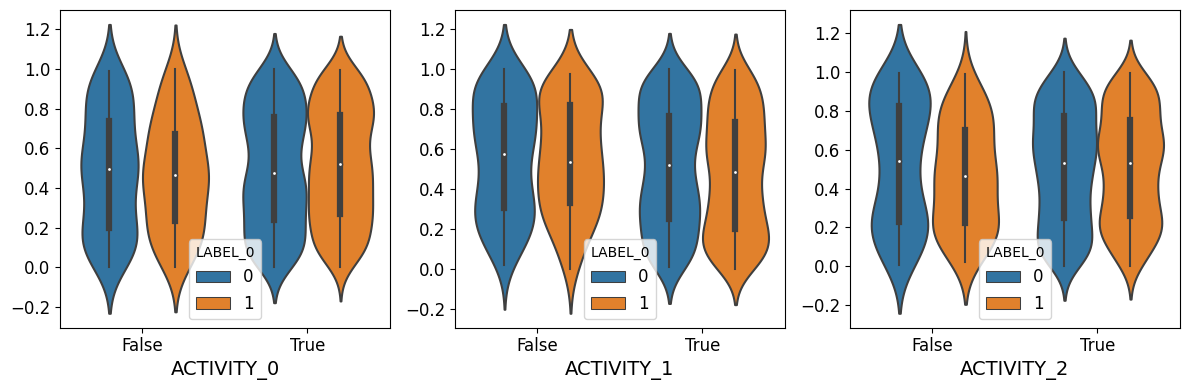

In [5]:
# Violin plots
eu.pl.violinplot(sdata, keys=['ACTIVITY_0', 'ACTIVITY_1', 'ACTIVITY_2'], groupby="TRAIN", hue="LABEL_0")

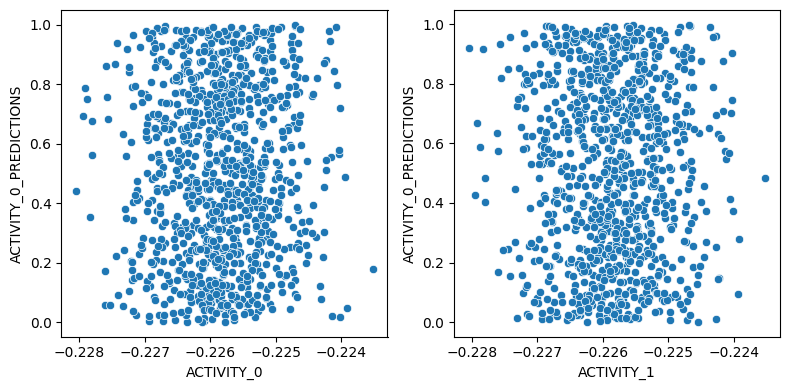

In [6]:
# Scatter plots
eu.pl.scatterplot(sdata, x=["ACTIVITY_0", "ACTIVITY_1"], y="ACTIVITY_0_PREDICTIONS")

# Training evaluation plotting functions (`_training.py`)

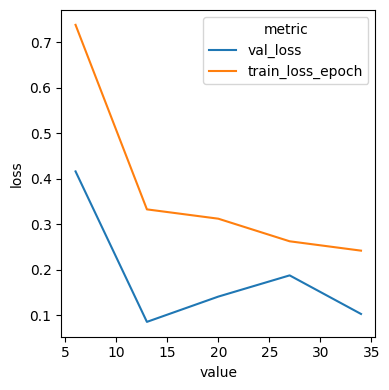

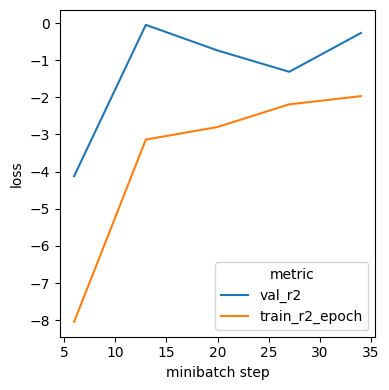

In [7]:
# Training curves
log_dir = "../_logs/default/version_0/"
eu.pl.training_summary(log_dir, metrics="r2")

# Regression evaluation plotting functions (`_regression.py`)

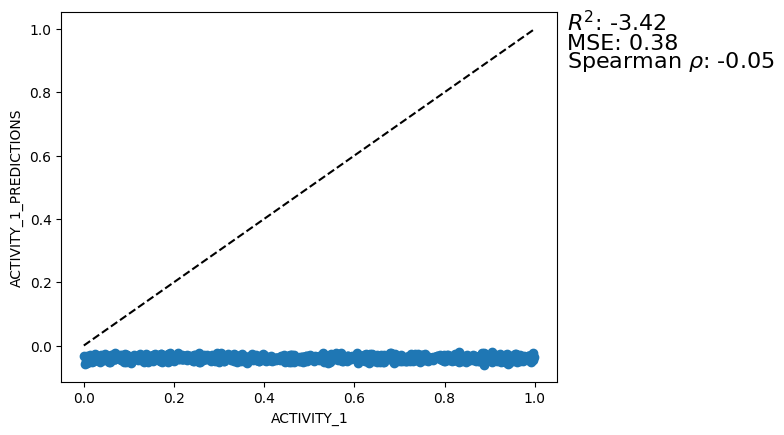

In [8]:
# Scatterplot of performance
eu.pl.performance_scatter(sdata, target="ACTIVITY_1", prediction="ACTIVITY_1_PREDICTIONS")

# Classification evaluation plotting functions (`_classification.py`)

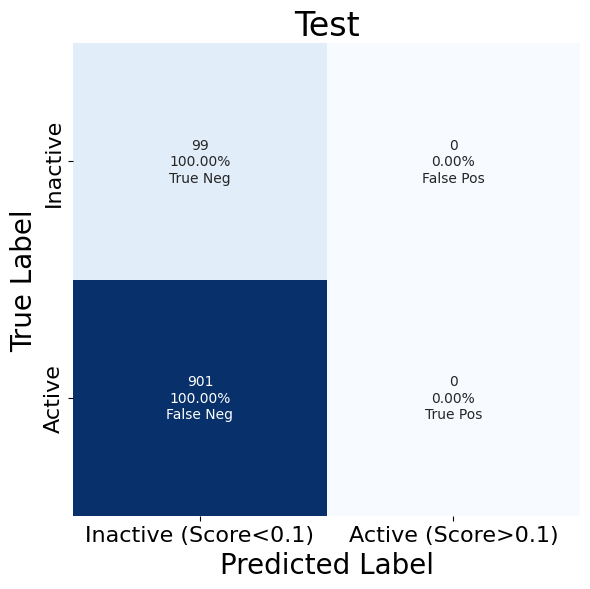

In [9]:
# Confusion matrix
eu.pl.confusion_mtx(sdata, target="ACTIVITY_0", prediction="ACTIVITY_0_PREDICTIONS", threshold=0.1, title="Test")

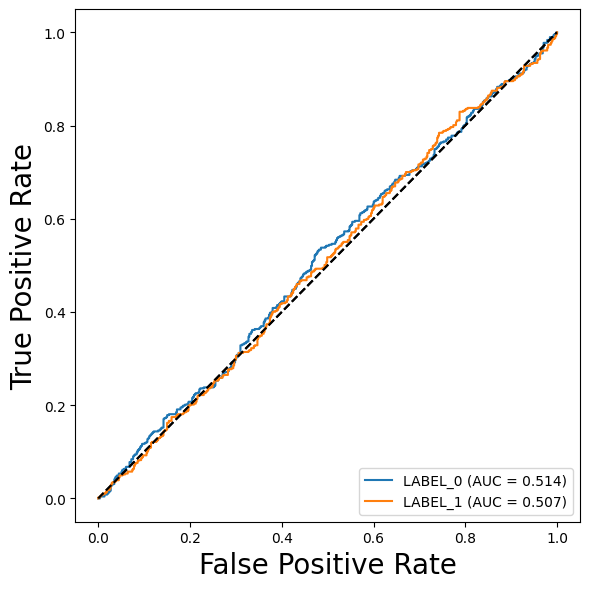

In [10]:
# Plot auroc curve
eu.pl.auroc(sdata, targets=["LABEL_0", "LABEL_0"], predictions=["ACTIVITY_0_PREDICTIONS", "ACTIVITY_1_PREDICTIONS"])

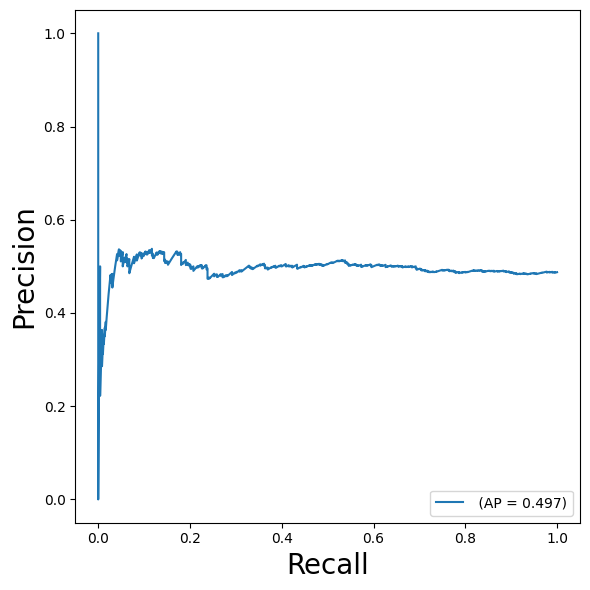

In [11]:
# Plot auprc curve
eu.pl.auprc(sdata, targets="LABEL_0", predictions="ACTIVITY_0_PREDICTIONS")

# Sequence plotting functions (`_seq.py`)

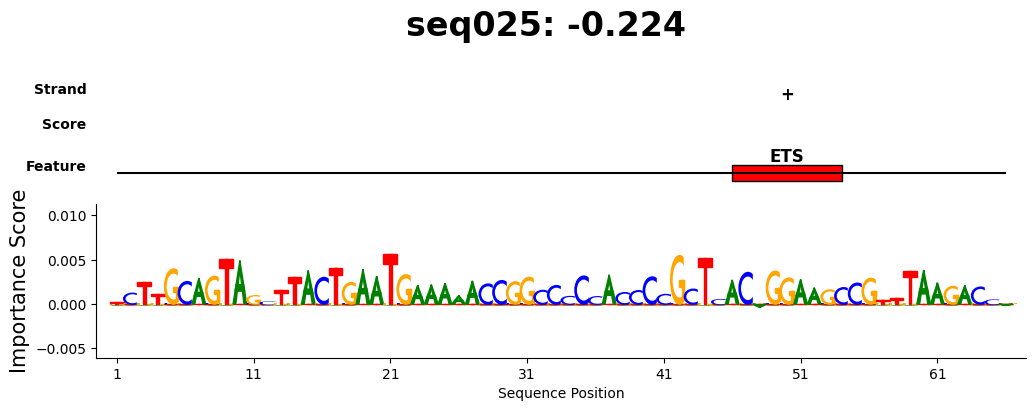

In [13]:
# Plot sequence logo based on feature importance
eu.pl.seq_track(sdata, seq_id=sdata.names[25], uns_key="InputXGradient_imps", pred_key="ACTIVITY_0_PREDICTIONS")

In [14]:
# Filter visualization
eu.pl.filter_viz(sdata, filter_id=0)

OSError: Could not find Ghostscript on path. There should be either a gs executable or a gswin32c.exe on your system's path

---

# Dimensionality reduction plotting functions (`_dim_reduce.py`)

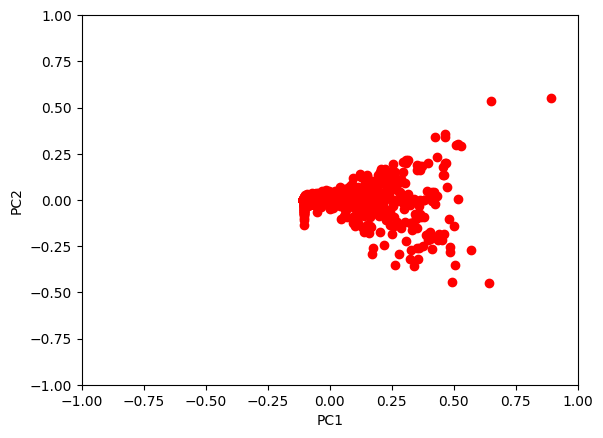

In [23]:
# PCA plotting
eu.pl.pca(sdata, seqsm_key="InputXGradient_imps_pca", color="r")

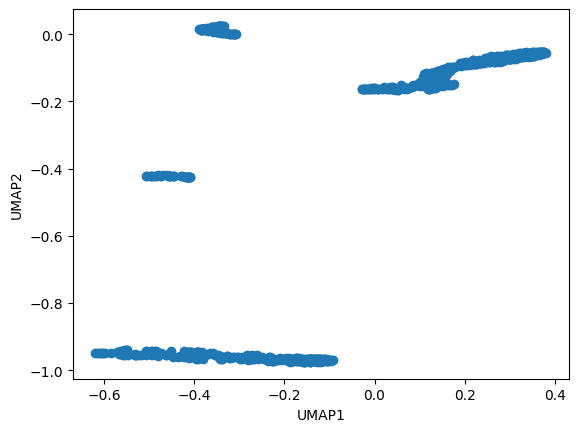

In [21]:
# UMAP plotting
eu.pl.umap(sdata, seqsm_key="InputXGradient_imps_umap")

# Scratch

In [ ]:
def _plot_histogram(sdata, keys: Union[str, Sequence[str]], title: str = None, xlab: str = None, ylab: str = "Frequency", **kwargs):
    keys = [keys] if isinstance(keys, str) else keys
    num_axes = len(keys)
    ax = _create_matplotlib_axes(num_axes, **kwargs)
    for i, key in enumerate(keys):
        curr_ax = ax[i] if len(keys) > 1 else ax
        row_index = int(np.ceil(i / 3))
        col_index = int(np.ceil(i / (row_index+1)))
        ps = sdata.seqs_annot[key].values.reshape(-1, 1)
        curr_ax.hist(ps, **kwargs)
        _label_plot(curr_ax, title, xlab=key if xlab is None else xlab, ylab=ylab)
    plt.show()
    return ax

def histogram(sdata, keys, rc_context=default_rc_context, **kwargs):
    with plt.rc_context(rc_context):
        _plot_histogram(sdata, keys, **kwargs)

In [ ]:
def _plot_curves(
    xs: Union[Sequence[Sequence[float]], Sequence[float]],
    ys: Union[Sequence[Sequence[float]], Sequence[float]],
    labels: Union[Sequence[str], str] = "",
    colors: Union[Sequence[str], str] = "bgrcmyk",
    **kwargs
):
    """
    Plots curves for multiple xs and ys.
    """
    if isinstance(xs, str):
        xs = [xs]
    if isinstance(ys, str):
        ys = [ys]
    if len(xs) != len(ys):
        raise ValueError("Number of xs and ys must be equal.")
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    if len(xs) == 1:
        _plot_curve(ax, xs[0], ys[0], **kwargs)
    else:
        for i, (target, prediction) in enumerate(zip(xs, ys)):
            _plot_curve(ax, xs[i], ys[i], **kwargs)
        plt.tight_layout()

In [ ]:
from eugene.preprocessing import ohe_DNA_seq
from eugene.preprocessing._utils import _collapse_pos
from vizsequence import viz_sequence

def _plot_seq_features(ax, seq, annots, additional_annots=["Affinity", "Closest consensus"]):
    h = 0.1  # height of TFBS rectangles
    ax.set_ylim(0, 1)  # lims of axis
    ax.spines['bottom'].set_visible(False)  #remove axis surrounding, makes it cleaner
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(left = False)  #remove tick marks on y-axis
    ax.set_yticks([0.25, 0.525, 0.75])  # Add ticklabel positions
    ax.set_yticklabels(["Feature"] + additional_annots, weight="bold")  # Add ticklabels
    ax.hlines(0.2, 1, len(seq), color="black")  #  Backbone to plot boxes on top of

    # Build rectangles for each TFBS into a dictionary
    for row, annot in annots.iterrows():
        start = annot["Start"]
        end = annot["End"]
        name = annot["Name"] if annot ["Name"] else "Unknown"
        strand = annot["Strand"] if annot["Strand"] else "Unknown"
        color = "red" if strand == "+" else "blue"
        feature_block = mpl.patches.Rectangle((start, 0.2-(h/2)), width=end-start+1, height=h, facecolor=color, edgecolor="black")
        ax.add_artist(feature_block)
        rx, ry = feature_block.get_xy()
        ytop = ry + feature_block.get_height()
        cx = rx + feature_block.get_width()/2.0
        ax.annotate(name, (cx, ytop), color='black', weight='bold', fontsize=12, ha='center', va='bottom')
        for i, add_annot in enumerate(additional_annots):
            if add_annot in annot.index:
                ax.annotate(annot[add_annot], (cx, 0.45 + i*0.2), color="black", weight='bold',
                            fontsize=12, ha='center', va='bottom')

def _plot_seq_logo(ax, seq, imp_scores=None, highlight=[], threshold=None):
    if imp_scores is None:
        print("No importance scores given, outputting just sequence")
        ylab = "Sequence"
        ax.spines['left'].set_visible(False)
        ax.set_yticklabels([])
        ax.set_yticks([])
        importance_scores = ohe_DNA_seq(seq)
    else:
        ylab = "Importance Score"

    # Plot the featue importance scores
    if len(highlight) > 0:
        to_highlight = {"red": _collapse_pos(highlight)}
        print(to_highlight)
        viz_sequence.plot_weights_given_ax(ax, importance_scores, subticks_frequency=10, highlight=to_highlight, height_padding_factor=1)
    else:
        viz_sequence.plot_weights_given_ax(ax, importance_scores, subticks_frequency=10, height_padding_factor=1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel("Sequence Position")
    ax.set_ylabel(ylab)
    if threshold is not None:
        ax.hlines(1, len(seq), threshold/10, color="red")

def _plot_seq(sdata, seq_id, uns_key = None, model_pred=None, threshold=None, highlight=[], cmap=None, norm=None, **kwargs):
    h = 0.1  # height of TFBS rectangles
    ax[0].set_ylim(0, 1)  # lims of axis
    ax[0].spines['bottom'].set_visible(False)  #remove axis surrounding, makes it cleaner
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['left'].set_visible(False)
    ax[0].tick_params(left = False)  #remove tick marks on y-axis
    ax[0].set_yticks([0.25, 0.525, 0.75])  # Add ticklabel positions
    ax[0].set_yticklabels(["Feature", "Metadata1", "Metadata2"], weight="bold")  # Add ticklabels
    ax[0].hlines(0.2, 1, len(seq), color="black")  #  Backbone to plot boxes on top of

    # Build rectangles for each TFBS into a dictionary
    for row, annot in p_annot.iterrows():
        start = annot["Start"]
        end = annot["End"]
        name = annot["Name"] if annot ["Name"] else "Unknown"
        strand = annot["Strand"] if annot["Strand"] else "Unknown"
        color = "red" if strand == "+" else "blue"
        feature_block = mpl.patches.Rectangle((start, 0.2-(h/2)), width=end-start, height=h, facecolor=color, edgecolor="black")
        ax[0].add_artist(feature_block)
        rx, ry = feature_block.get_xy()
        ytop = ry + feature_block.get_height()
        cx = rx + feature_block.get_width()/2.0
        ax[0].annotate(name, (cx, ytop), color='black', weight='bold', fontsize=12, ha='center', va='bottom')
        if "Affinity" in p_annot.columns:
        ax[0].annotate("(%s)" % strand, (cx, ytop), color='black', weight='bold', fontsize=12, ha='center', va='top')
        ax[0].annotate(tfbs_aff, (cx, 0.45), color=r.get_facecolor(), weight='bold',
                        fontsize=12, ha='center', va='bottom')
        ax[0].annotate(closest_match, (cx, 0.65), color="black", weight='bold',
                        fontsize=12, ha='center', va='bottom')
        ax[0].annotate(str(spacing), (((rx-spacing) + rx)/2, 0.25), weight='bold', color="black",
                    fontsize=12, ha='center', va='bottom')

fig, ax = plt.subplots(2, 1, figsize=(12,4), sharex=True)
plt.subplots_adjust(wspace=0, hspace=0)
_plot_seq_features(ax[0], seq, p_annot, additional_annots=["Score", "Strand"])
_plot_seq_logo(ax[1], seq, imp_scores=None, highlight=[])

# Define subplots
    fig, ax = plt.subplots(2, 1, figsize=(12,4), sharex=True)
    plt.subplots_adjust(wspace=0, hspace=0)

    # Build the annotations in the first subplot
    h = 0.1  # height of TFBS rectangles
    ax[0].set_ylim(0, 1)  # lims of axis
    ax[0].spines['bottom'].set_visible(False)  #remove axis surrounding, makes it cleaner
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['left'].set_visible(False)
    ax[0].tick_params(left = False)  #remove tick marks on y-axis
    ax[0].set_yticks([0.25, 0.525, 0.75])  # Add ticklabel positions
    ax[0].set_yticklabels(["TFBS", "Affinity", "Closest OLS Hamming Distance"], weight="bold")  # Add ticklabels
    ax[0].hlines(0.2, 1, len(seq), color="black")  #  Backbone to plot boxes on top of

    # Build rectangles for each TFBS into a dictionary
    tfbs_blocks = {}
    for pos in tfbs_annot.keys():
        if tfbs_annot[pos][0] == "GATA":
            tfbs_blocks[pos] = mpl.patches.Rectangle((pos-2, 0.2-(h/2)), width=8, height=h, facecolor="orange", edgecolor="black")
        elif tfbs_annot[pos][0] == "ETS":
            tfbs_blocks[pos] = mpl.patches.Rectangle((pos-2, 0.2-(h/2)), width=8, height=h, facecolor="blue", edgecolor="black")

    # Plot the TFBS with annotations, should be input into function
    for pos, r in tfbs_blocks.items():
        ax[0].add_artist(r)
        rx, ry = r.get_xy()
        ytop = ry + r.get_height()
        cx = rx + r.get_width()/2.0
        tfbs_site = tfbs_annot[pos][0] + tfbs_annot[pos][1]
        tfbs_aff = round(tfbs_annot[pos][3], 2)
        closest_match = tfbs_annot[pos][5] + ": " + str(tfbs_annot[pos][7])
        spacing = tfbs_annot[pos][4]
        ax[0].annotate(tfbs_site, (cx, ytop), color='black', weight='bold',
                    fontsize=12, ha='center', va='bottom')
        ax[0].annotate(tfbs_aff, (cx, 0.45), color=r.get_facecolor(), weight='bold',
                    fontsize=12, ha='center', va='bottom')
        ax[0].annotate(closest_match, (cx, 0.65), color="black", weight='bold',
                    fontsize=12, ha='center', va='bottom')
        ax[0].annotate(str(spacing), (((rx-spacing) + rx)/2, 0.25), weight='bold', color="black",
                fontsize=12, ha='center', va='bottom')